In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

In [2]:
import jax
import hlax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training.train_state import TrainState
from torchvision.datasets import FashionMNIST

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [4]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [14]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## Setup

In [15]:
key = jax.random.PRNGKey(314)
key_vae, key_train, key_samples = jax.random.split(key, 3)

In [16]:
dim_latent = 50
n_epochs = 1000

## VAE 

In [17]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

In [18]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [19]:
batch_size = 200
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

Decoder = hlax.models.HomkDecoder
model = hlax.models.VAE_IW(dim_latent, dim_obs, Encoder, Decoder)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [20]:
tx = optax.adam(1e-3)
state = TrainState.create(
    apply_fn=partial(model.apply, num_samples=50),
    params=params_init,
    tx=tx
)

In [21]:
keys_train = jax.random.split(key_train, n_epochs)
hist_vae_loss = []

loss_old = -jnp.inf
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = hlax.vae.train_epoch(keyt, state, X_train, batch_size)
    
    hist_vae_loss.append(loss)
        
    pbar.set_description(f"{loss=:.3e}")
params_vae = state.params

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
hist_vae_mll = -jnp.array(hist_vae_loss)

## Minibatch

In [128]:
%%time

decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.adam(1e-3)
tx_latent = optax.adam(1e-4)

key_init, key_step = jax.random.split(key_train)

states = hlax.hard_decoder.initialise_state(key, decoder, tx_params,
                                            tx_latent, X_train, dim_latent)
opt_states, target_states = states
params_decoder, z_decoder = target_states

 
n_its_params, n_its_latent = 20, 50
nll_hist = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch_adam(key_step, params_decoder, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder, z_decoder, opt_states = res
    nll_hist.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.8 s, sys: 3.47 s, total: 16.3 s
Wall time: 13.3 s


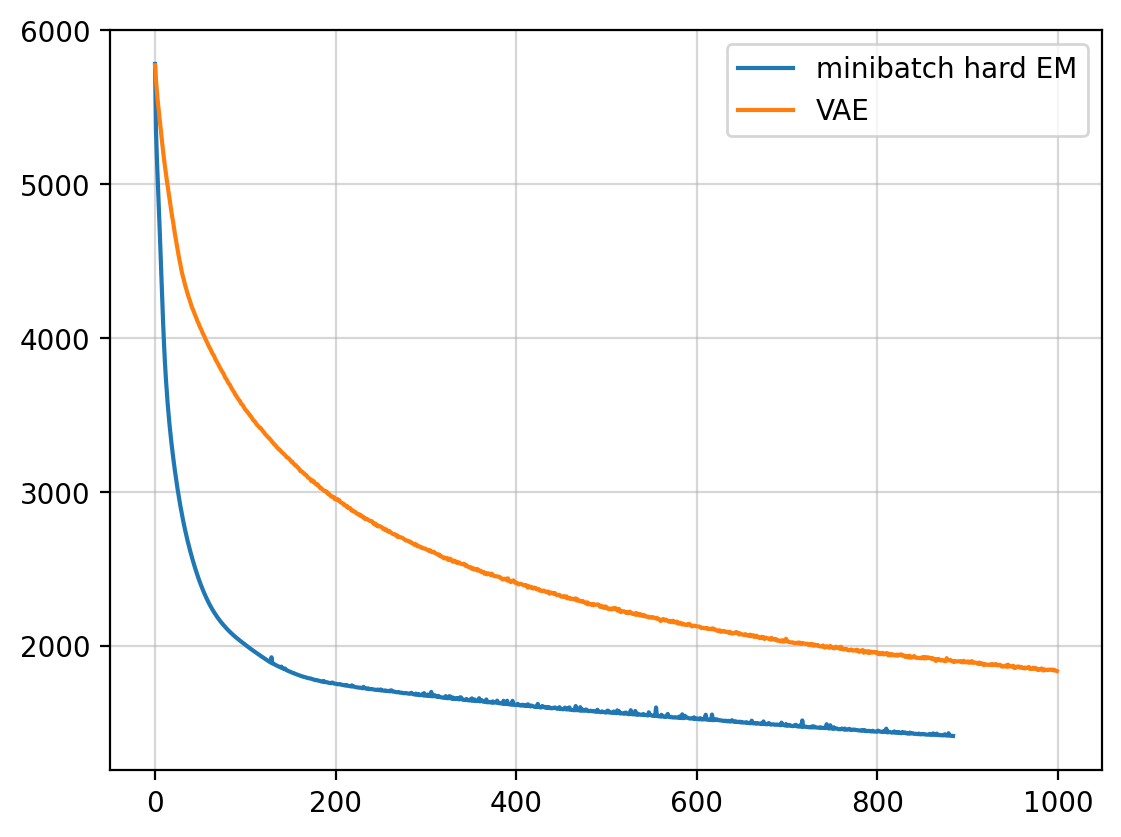

In [129]:
plt.plot(nll_hist, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
# plt.xscale("log")
plt.grid(alpha=0.5)

## Analysing posterior observations

In [93]:
def clean_axis(ax):
    """
    Source
    https://stackoverflow.com/questions/49155654
    """
    # make xaxis invisibel
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)


In [94]:
n_samples = 8
key_choice, keys_is = jax.random.split(key_samples)
keys_is = jax.random.split(keys_is, n_samples)

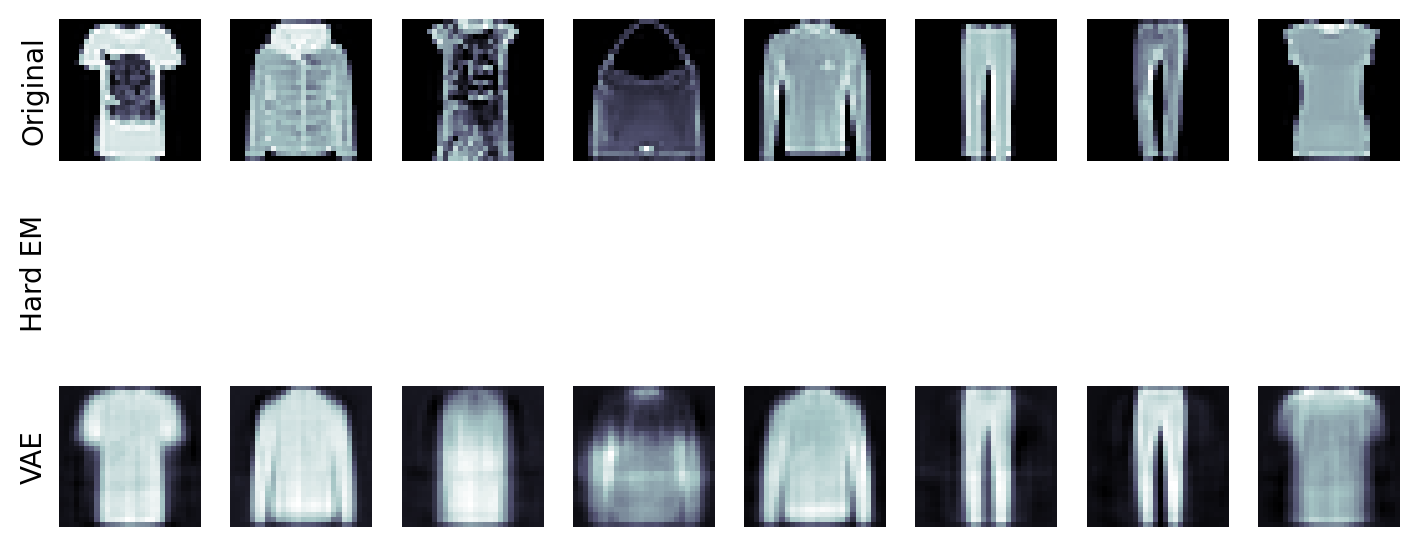

In [95]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, axs = plt.subplots(3, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(axs.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder[ix])
    _, _, (mean_x_vae, logvar_x_vae) = model.apply(params_vae, obs, key)
    

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[2].imshow(mean_x_vae.reshape(28, 28), cmap=cmap)
    
    for axi in ax:
        clean_axis(axi)
        
plt.tight_layout()

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Hard EM")
axs[2, 0].set_ylabel("VAE");